INSTALLATIONS

In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1
!pip install -U segmentation-models-pytorch
!pip install --upgrade albumentations

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:22tcmalloc: large alloc 1147494400 bytes == 0x557e27cb0000 @  0x7f2ed832a615 0x557ded7b702c 0x557ded89717a 0x557ded7b9e4d 0x557ded8abc0d 0x557ded82e0d8 0x557ded828c35 0x557ded7bb73a 0x557ded82df40 0x557ded828c35 0x557ded7bb73a 0x557ded82a93b 0x557ded8aca56 0x557ded829fb3 0x557ded8aca56 0x557ded829fb3 0x557ded8aca56 0x557ded829fb3 0x557ded7bbb99 0x557ded7fee79 0x557ded7ba7b2 0x557ded82de65 0x557ded828c35 0x557ded7bb73a 0x557ded82a93b 0x557ded828c35 0x557ded7bb73a 0x557ded829b0e 0x557ded7bb65a 0x557ded829d67 0x557ded828c35
     |█████████████████               | 1055.7 MB 1.6 MB/s eta 0:09:56tcmalloc: large alloc 1434370048 bytes == 0x557e6c306000 @  0x7f2ed832a615 0x557ded7b702c 0x557ded89717a 0x557ded7b9e4d 0x557ded8abc0d 0x557ded82e0d8 0x557ded828c35 0x557ded7bb73a 0x557ded82df40 0x557ded828c35 0x557ded7bb73a 0x557ded82a93b 0x557ded8aca56 0x557de

MOUNT DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


IMPORTS

In [3]:
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc
import albumentations as A
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

#fix seeds
torch.manual_seed(0)
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

LOAD DATA FROM ZIP 


In [4]:
# unzip the dataset
try:
      !unzip '/content/gdrive/My Drive/road_segmentation/toronto_light.zip'
      !unzip '/content/gdrive/My Drive/road_segmentation/cil-road-segmentation-2021.zip'
      !mv training/training/* training
      !rm -rf training/training

except:
      print('Please upload a .zip file containing your datasets.')


Archive:  /content/gdrive/My Drive/road_segmentation/toronto_less_light.zip
   creating: toronto_less_light/
  inflating: toronto_less_light/.DS_Store  
  inflating: __MACOSX/toronto_less_light/._.DS_Store  
   creating: toronto_less_light/images/
   creating: toronto_less_light/groundtruth/
  inflating: toronto_less_light/images/test-img-16-13.png  
  inflating: __MACOSX/toronto_less_light/images/._test-img-16-13.png  
  inflating: toronto_less_light/images/test-img-6-6.png  
  inflating: __MACOSX/toronto_less_light/images/._test-img-6-6.png  
  inflating: toronto_less_light/images/test-img-18-4.png  
  inflating: __MACOSX/toronto_less_light/images/._test-img-18-4.png  
  inflating: toronto_less_light/images/test-img-8-9.png  
  inflating: __MACOSX/toronto_less_light/images/._test-img-8-9.png  
  inflating: toronto_less_light/images/test-img-14-9.png  
  inflating: __MACOSX/toronto_less_light/images/._test-img-14-9.png  
  inflating: toronto_less_light/images/test-img-21-0.png  
  inf

In [5]:
#load data into np array function
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

#load data
imgs  = load_all_from_path(os.path.join('training', 'images'))
masks = load_all_from_path(os.path.join('training', 'groundtruth'))

imgs_toronto  = load_all_from_path(os.path.join('toronto_light', 'images'))
masks_toronto = load_all_from_path(os.path.join('toronto_light', 'groundtruth'))

#all images and masks
imgs = np.concatenate((imgs,imgs_toronto), axis = 0)
masks = np.concatenate((masks,masks_toronto), axis = 0)


VISUALIZE FIRST N IMAGES AND MASKS

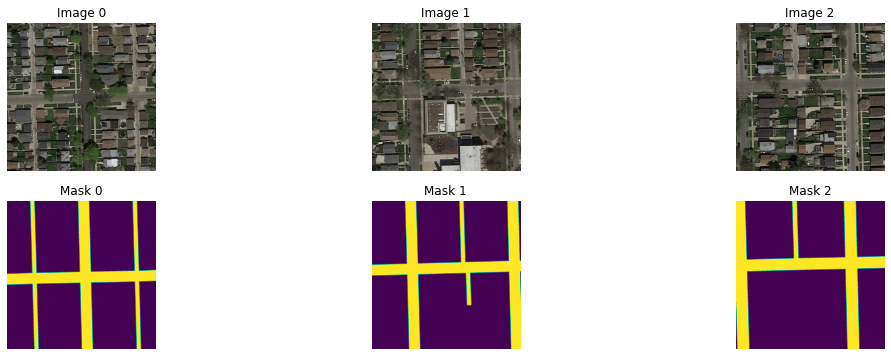

In [6]:
def show_first_n(imgs, masks, n=3):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


show_first_n(imgs, masks)

TRAINING AND VALIDATION SPLIT

In [7]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.10, shuffle=True, random_state=42)

DATASET 

In [8]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu().float()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True).float()



class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, imgs, masks, path, device, use_patches=False, resize_to=(400, 400), transform=None, preprocessing = None):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.transform = transform
        self.preprocessing = preprocessing
        self.x, self.y = imgs, masks
        self.n_samples = len(self.x)
        if self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        #self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC


    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing 
    
        if self.transform is not None:
            transformed = self.transform(image = x)
            x = transformed['image']
            y = transformed['mask']

        return x, y


    def __getitem__(self, item):      
         # apply augmentations
        if self.transform:
            sample = self.transform(image= self.x[item], mask= self.y[item])
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image= self.x[item], mask= self.y[item])
            image, mask = sample['image'], sample['mask']
            
        image = np.moveaxis(image, -1, 0)
        return (np_to_tensor(image, self.device), np_to_tensor(mask, self.device))


    def __len__(self):
        return self.n_samples



def show_val_samples(x, y, y_hat, segmentation=False):
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

TRAIN FUNCTION

In [9]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs, patience, scheduler):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    max_val_patch_acc = 0
    epochs_no_improve = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            gc.collect()
            y_hat = model(x)  # forward pass
            y = y.unsqueeze(1)
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x) # forward pass
                y = y.unsqueeze(1)
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())



        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizer.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)



        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          best_model = copy.deepcopy(model.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              model.load_state_dict(best_model)
              break
        


    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

PRE TRAINED MODELS

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
model_xception = smp.Unet(
    encoder_name='xception', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      
    classes=1, 
).to(device)

preprocessing_fn_xception = smp.encoders.get_preprocessing_fn('xception', 'imagenet')


model_resnet = smp.Unet(
    encoder_name='se_resnet50', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      
    classes=1, 
).to(device)

preprocessing_fn_resnet = smp.encoders.get_preprocessing_fn('se_resnet50', 'imagenet')


model_vgg = smp.Unet(
    encoder_name='vgg19_bn', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',      
    classes=1, 
).to(device)

preprocessing_fn_vgg = smp.encoders.get_preprocessing_fn('vgg19_bn', 'imagenet')


model_efficientnet = smp.Unet(
    encoder_name='efficientnet-b5', 
    encoder_weights='imagenet',
    decoder_use_batchnorm = True, 
    activation='sigmoid',     
    classes=1, 
).to(device)

preprocessing_fn_efficientnet = smp.encoders.get_preprocessing_fn('efficientnet-b5', 'imagenet')

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth" to /root/.cache/torch/hub/checkpoints/se_resnet50-ce0d4300.pth


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


TRAINING AUGMENTATIONS

In [11]:
def get_preprocessing(preprocessing_fn=None):
    transform = []
    transform.append(A.Lambda(image=preprocessing_fn))        
    return A.Compose(transform)


def get_training_augmentation():
    transform = [    
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1)
            ],
            p=0.75,
        ),

        A.OneOf(
            [
               A.RandomContrast(limit=.6, p=1),
               A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
               A.RandomBrightness(limit=0.2, p=1)
            ],
            p=0.75,
        ),
       
         A.IAAAdditiveGaussianNoise(p=0.2),
  
    ]
    return A.Compose(transform)

METRICS

In [12]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()


def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

TRAIN THE MODELS

In [ ]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_efficientnet), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_efficientnet))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker, generator=g)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model_efficientnet.parameters())
#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)
n_epochs = 70
patience_early_stop = 10

train(train_dataloader, val_dataloader, model_efficientnet, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_efficientnet.state_dict(), 'u_net_efficientnet.pth')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_resnet), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_resnet))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model_resnet.parameters())
#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)
n_epochs = 70
patience_early_stop = 10
train(train_dataloader, val_dataloader, model_resnet, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_resnet.state_dict(), 'u_net_resnet.pth')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_xception), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_xception))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model_xception.parameters())
#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)
n_epochs = 70
patience_early_stop = 10

train(train_dataloader, val_dataloader, model_xception, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_xception.state_dict(), 'u_net_xception.pth')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_vgg), transform= get_training_augmentation())
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384), preprocessing=get_preprocessing(preprocessing_fn_vgg))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True,worker_init_fn=seed_worker,generator=g)

loss_fn = nn.BCELoss()
#loss_fn = smp.utils.losses.DiceLoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model_vgg.parameters())
#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5,min_lr = 0.0000001)
n_epochs = 70
patience_early_stop = 10

train(train_dataloader, val_dataloader, model_vgg, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
torch.save(model_vgg.state_dict(), 'u_net_vgg.pth')

Output hidden; open in https://colab.research.google.com to view.

PREDICT ON TEST

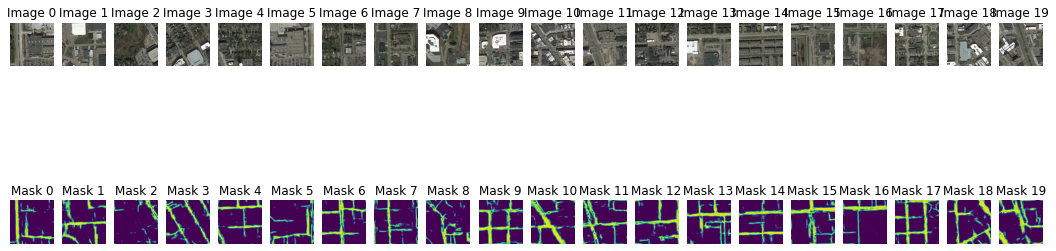

In [18]:
#apply preprocessing on test images
def apply_preprocessing_on_test(images, preprocessing):
  new_images = []
  for image in images:
    sample = get_preprocessing(preprocessing)(image= image)
    new_images.append(sample['image'])
  return np.array(new_images)

#merge the predictions, returns the mean of the predictions
def merge(test_pred_resnet, test_pred_xception,test_pred_vgg, test_pred_efficientnet):
  new_imgs = []
  for indx in range(len(test_pred_resnet)):
      new_imgs.append( np.mean(np.array([test_pred_resnet[indx], test_pred_xception[indx],test_pred_vgg[indx],test_pred_efficientnet[indx]]), axis = 0) )

  return np.array(new_imgs)


# predict on test set
test_filenames = (glob('test_images/test_images' + '/*.png'))
test_images = load_all_from_path('test_images/test_images')
batch_size = test_images.shape[0]
size = test_images.shape[1:3]

# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)


test_images_resnet = apply_preprocessing_on_test(test_images, preprocessing_fn_resnet )
test_images_tensor_resnet = np_to_tensor(np.moveaxis(test_images_resnet, -1, 1), device)
test_pred_resnet = [model_resnet(t).detach().cpu().numpy() for t in test_images_tensor_resnet.unsqueeze(1)]
test_pred_resnet = np.concatenate(test_pred_resnet, 0)
test_pred_resnet = np.moveaxis(test_pred_resnet, 1, -1)  # CHW to HWC
test_pred_resnet = np.stack([cv2.resize(img, dsize=size) for img in test_pred_resnet], 0)  # resize to original shape


test_images_xception = apply_preprocessing_on_test(test_images, preprocessing_fn_xception )
test_images_tensor_xception = np_to_tensor(np.moveaxis(test_images_xception, -1, 1), device)
test_pred_xception = [model_xception(t).detach().cpu().numpy() for t in test_images_tensor_xception.unsqueeze(1)]
test_pred_xception = np.concatenate(test_pred_xception, 0)
test_pred_xception = np.moveaxis(test_pred_xception, 1, -1)  # CHW to HWC
test_pred_xception = np.stack([cv2.resize(img, dsize=size) for img in test_pred_xception], 0)  # resize to original shape


test_images_vgg = apply_preprocessing_on_test(test_images, preprocessing_fn_vgg )
test_images_tensor_vgg = np_to_tensor(np.moveaxis(test_images_vgg, -1, 1), device)
test_pred_vgg = [model_vgg(t).detach().cpu().numpy() for t in test_images_tensor_vgg.unsqueeze(1)]
test_pred_vgg = np.concatenate(test_pred_vgg, 0)
test_pred_vgg = np.moveaxis(test_pred_vgg, 1, -1)  # CHW to HWC
test_pred_vgg = np.stack([cv2.resize(img, dsize=size) for img in test_pred_vgg], 0)  # resize to original shape


test_images_efficientnet = apply_preprocessing_on_test(test_images, preprocessing_fn_efficientnet )
test_images_tensor_efficientnet = np_to_tensor(np.moveaxis(test_images_efficientnet, -1, 1), device)
test_pred_efficientnet = [model_efficientnet(t).detach().cpu().numpy() for t in test_images_tensor_efficientnet.unsqueeze(1)]
test_pred_efficientnet = np.concatenate(test_pred_efficientnet, 0)
test_pred_efficientnet = np.moveaxis(test_pred_efficientnet, 1, -1)  # CHW to HWC
test_pred_efficientnet = np.stack([cv2.resize(img, dsize=size) for img in test_pred_efficientnet], 0)  # resize to original shape


#ensemble predictions
test_pred = merge(test_pred_resnet, test_pred_xception,test_pred_vgg, test_pred_efficientnet )

#show results
show_first_n(test_images, test_pred, n = 20)


CREATE SUBMISSION

In [19]:
PATCH_SIZE= 16
CUTOFF = 0.25

#function to create the submission file
def create_submission(labels, test_filenames, submission_filename):
    test_path='test_images/test_images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')